In [49]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# confirm GPU is in play
assert tf.test.is_gpu_available()
assert tf.test.is_built_with_cuda()

2023-01-05 11:34:26.654805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6


Implementing a basic linear classifier to learn some lower level TensorFlow programming.

Following DL with Python by Chollet, Chapter 3.

In [ ]:
# generate data
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_samples_per_class)
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                    np.ones((num_samples_per_class, 1), dtype="float32")))

loss at step 0: 3.8416
loss at step 10: 0.0835
loss at step 20: 0.0462
loss at step 30: 0.0322
loss at step 40: 0.0269
loss at step 50: 0.0249


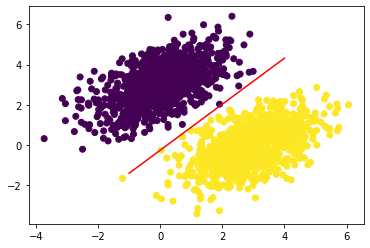

In [63]:
# create linear classifier
input_dim  = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

def model(inputs):
    return tf.matmul(inputs, W)+b

# build optimization functions
def square_loss(targets, predictions):
    return tf.reduce_mean(tf.square(targets-predictions))

def training_step(inputs, targets, learning_rate=0.1):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    gradient_loss_wrt_w, gradient_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(gradient_loss_wrt_w * learning_rate)
    b.assign_sub(gradient_loss_wrt_b * learning_rate)
    return loss

# train
for step in range(60):
    loss = training_step(inputs, targets)
    if (step%10)==0:
        print(f"loss at step {step}: {loss:.4f}")

# predict
yhats = model(inputs)

# show results
x = np.linspace(-1, 4, 100)
y = -W[0] / W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, '-r')
plt.scatter(inputs[:, 0], inputs[:, 1], c=yhats[:, 0] > 0.5)
plt.show()

Implementing a basic linear classifier using Keras API.

Following DL with Python by Chollet, Chapter 3.

In [56]:
class SimpleDense(keras.layers.Layer):
    ''' simple template of custom class for building neural network with keras api. '''
    def __int__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units), initializer="uniform") 
        self.b = self.add_weight(shape=(self.units, ), initializer="zeros") 

    def call(self, inputs):
        # note: best practice to put forward pass in call() method
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [78]:
# let's build a similar architecture but with higher level keras functionality
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs     = inputs[indices_permutation]
shuffled_targets    = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=32,
    validation_data=(val_inputs, val_targets)
)

loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

predictions = model.predict(val_inputs, batch_size=128)
predictions

Epoch 1/5
44/44 [==============================] - 1s 8ms/step - loss: 0.1488 - binary_accuracy: 0.9686 - val_loss: 0.1742 - val_binary_accuracy: 0.9650
Epoch 2/5
44/44 [==============================] - 0s 6ms/step - loss: 0.1465 - binary_accuracy: 0.9700 - val_loss: 0.1707 - val_binary_accuracy: 0.9667
Epoch 3/5
44/44 [==============================] - 0s 6ms/step - loss: 0.1445 - binary_accuracy: 0.9707 - val_loss: 0.1677 - val_binary_accuracy: 0.9667
Epoch 4/5
44/44 [==============================] - 0s 6ms/step - loss: 0.1346 - binary_accuracy: 0.9743 - val_loss: 0.1466 - val_binary_accuracy: 0.9683
Epoch 5/5
5/5 [==============================] - 0s 1ms/step


array([[ 4.104955  ],
       [-1.9025239 ],
       [-0.47968698],
       [ 3.6515498 ],
       [-1.4549549 ],
       [ 3.2664304 ],
       [ 2.3784912 ],
       [ 4.700443  ],
       [-0.9861782 ],
       [ 1.5880126 ],
       [-2.1661806 ],
       [-1.1029837 ],
       [ 4.3381696 ],
       [ 0.02291107],
       [ 1.3427143 ],
       [-1.690912  ],
       [ 3.3637724 ],
       [-0.48602778],
       [ 3.3520274 ],
       [-1.7099581 ],
       [ 4.4682546 ],
       [ 0.01182699],
       [-1.4766413 ],
       [ 2.6571963 ],
       [ 4.398661  ],
       [-1.67532   ],
       [-2.3939002 ],
       [ 3.5482647 ],
       [-1.5753933 ],
       [ 2.6961038 ],
       [ 2.3825154 ],
       [-1.7431229 ],
       [-1.690911  ],
       [-1.5183762 ],
       [-1.0791274 ],
       [ 3.2406108 ],
       [ 3.5757656 ],
       [-2.105576  ],
       [ 2.49778   ],
       [-0.4078021 ],
       [ 0.12166535],
       [ 2.584966  ],
       [ 2.3174846 ],
       [-1.6978372 ],
       [-1.8835665 ],
       [ 2

Implementing some lower level keras functionality.

Following DL with Python by Chollet, Chapter 7.

Just to note for myself; Keras has three different ways to use APIs for building models:
 - Sequential: most simple; effectively a list of layers.
 - Functional: graph-like model architecture where we build the model but get a lot of built-in features.
 - Model subclassing: build everything from scratch to have full control, but could make mistakes!


Chollet recommends the use of the Functional API that makes use of subclassed layers to provide the best of both worlds: high development flexibility while retaining the advantages of the functional API (e.g. model summary, graph of our model, dont have to code all from scratch, etc.).

In [14]:
# build a custom mnist model
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

def get_mnist_model():
    inputs = keras.Input(shape=(28*28, ))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28*28)).astype('float32') / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
    epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2950 - accuracy: 0.9124 - val_loss: 0.1543 - val_accuracy: 0.9573
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1644 - accuracy: 0.9541 - val_loss: 0.1228 - val_accuracy: 0.9660
Epoch 3/3
313/313 [==============================] - 1s 2ms/step


In [18]:
# implementing a custom metric
class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples',
            initializer='zeros', dtype='int32')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)


In [16]:
# test drive new metric
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', RootMeanSquaredError()])
model.fit(train_images, train_labels,
    epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2945 - accuracy: 0.9131 - rmse: 7.1786 - val_loss: 0.1629 - val_accuracy: 0.9545 - val_rmse: 7.3554
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1637 - accuracy: 0.9539 - rmse: 7.3569 - val_loss: 0.1194 - val_accuracy: 0.9675 - val_rmse: 7.3965
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1030 - accuracy: 0.9727 - rmse: 7.4347


In [ ]:
# let's learn about callbacks, among:
# checkpoint, earlystopping, learningratescheduler, reuce learnign rate on plateau, and csv logger

# straightforward; just need to remember what is available in the toolkit!

# add
# @tf.function 
# as decorator of a function that we want to fully compile before running a model so it is not executed greedly line by line

Let's implement some CNNs.

Following DL with Python by Chollet, Chapter 8.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [1]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)


2023-01-31 13:59:32.403116: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-31 13:59:34.239609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 13:59:34.810165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5304 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
    epochs=5, batch_size=64)

Epoch 1/5


2023-01-31 14:04:50.645768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-31 14:04:56.146137: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 13s 6ms/step - loss: 0.1536 - accuracy: 0.9520
Epoch 2/5
938/938 [==============================] - 5s 6ms/step - loss: 0.0434 - accuracy: 0.9869
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0306 - accuracy: 0.9906
Epoch 4/5
938/938 [==============================] - 5s 6ms/step - loss: 0.0235 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 5s 6ms/step - loss: 0.0180 - accuracy: 0.9943


In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc:.3f}')
# hot dang

313/313 [==============================] - 1s 3ms/step - loss: 0.0264 - accuracy: 0.9920
Test accuracy: 0.992


Chollet chapter 13:

Turn on mixed precision in tensorflow which will automatically use smaller floats (i.e. float 16) where we don't need the precision and then use more precision (i.e. float32) where we do, e.g. calculating gradients.



In [1]:
from tensorflow import keras
keras.mixed_precision.set_global_policy("mixed_float16")

2023-02-03 09:58:31.424262: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6
